# Binary Classification Model for CycleGAN Horse vs. Zebra Using TensorFlow Take 3
### David Lowe
### October 27, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The CycleGAN Horse vs. Zebra dataset is a binary classification situation where we attempt to predict one of the two possible outcomes.

INTRODUCTION: The CycleGAN dataset collection contains datasets that consist of images from two classes A and B (for example, apple vs. orange, horses vs. zebras, and so on). The researchers used the images to train machine learning models for research work in the area of General Adversarial Networks.

In iteration Take1, we constructed and tuned machine learning models for this dataset using TensorFlow with a simple VGG-1 network. We also observed the best result that we could obtain using the test dataset.

In iteration Take2, we constructed and tuned machine learning models for this dataset using TensorFlow with a VGG-2 network. We also observed the best result that we could obtain using the test dataset.

This Take3 iteration will construct and tune machine learning models for this dataset using TensorFlow with a VGG-3 network. We will also observe the best result that we can obtain using the test dataset.

ANALYSIS: In iteration Take1, the baseline model's (one layer with eight convolutional filters) performance achieved an accuracy score of 88.85% after 15 epochs using the unseen test dataset. After experimenting with different layer configurations, the best model (one layer with 64 convolutional filters) processed the validation dataset with 91.15% accuracy.

In iteration Take2, the baseline model's (two layers with 8/16 convolutional filters) performance achieved an accuracy score of 90.00% after 15 epochs using the unseen test dataset. After experimenting with different layer configurations, the best model (two layers with 32/64 convolutional filters) processed the validation dataset with 91.92% accuracy.

In this Take3 iteration, the baseline model's (three layers with 8|16|32 convolutional filters) performance achieved an accuracy score of 91.92% after 15 epochs using the unseen test dataset. After experimenting with different layer configurations, the best model (three layers with 48|96|192 convolutional filters) processed the test dataset with 96.54% accuracy.

CONCLUSION: In this iteration, the best TensorFlow model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: CycleGAN Horse vs. Zebra Dataset

Dataset ML Model: Binary classification with numerical attributes

Dataset Reference: https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/

One potential source of performance benchmarks: https://arxiv.org/abs/1703.10593 or https://junyanz.github.io/CycleGAN/

A deep-learning modeling project generally can be broken down into five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

# Task 1 - Prepare Environment

In [1]:
# Install the packages to support accessing environment variable and SQL databases
!pip install python-dotenv PyMySQL boto3

     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 133kB 8.7MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 6.7MB 14.2MB/s 
     |████████████████████████████████| 133kB 53.8MB/s 
ERROR: kaggle 1.5.8 has requirement urllib3<1.25,>=1.21.1, but you'll have urllib3 1.25.11 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
# Retrieve GPU configuration information from Colab
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Sat Oct 24 15:06:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Retrieve memory configuration information from Colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
    print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
    print('re-execute this cell.')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 13.7 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime → "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [4]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 2


## 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import boto3
import zipfile
from datetime import datetime
from dotenv import load_dotenv
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set Pandas options
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5
n_iterations = 2

# Set various default modeling parameters
default_loss = 'binary_crossentropy'
default_metrics = ['accuracy']
default_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 15
default_batch = 32
default_image_size = (256, 256)
default_image_shape = (256, 256, 3)

# Define the labels to use for graphing the data
train_metric = "accuracy"
validation_metric = "val_accuracy"
train_loss = "loss"
validation_loss = "val_loss"

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.3.0


In [8]:
# Set up the parent directory location for loading the dotenv files
# useColab = False
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = False
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

In [9]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [10]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [11]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

## 1.c) Load dataset

In [12]:
!rm -rf horse2zebra/
!rm horse2zebra.zip

rm: cannot remove 'horse2zebra.zip': No such file or directory


In [13]:
!wget https://dainesanalytics.com/datasets/tensorflow-taesungpark-cyclegan-datasets/horse2zebra.zip

--2020-10-24 15:06:53--  https://dainesanalytics.com/datasets/tensorflow-taesungpark-cyclegan-datasets/horse2zebra.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.32.240.32, 13.32.240.101, 13.32.240.72, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.32.240.32|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116867962 (111M) [application/zip]
Saving to: ‘horse2zebra.zip’

horse2zebra.zip     100%[===================>] 111.45M  91.1MB/s    in 1.2s    

2020-10-24 15:06:54 (91.1 MB/s) - ‘horse2zebra.zip’ saved [116867962/116867962]



In [14]:
local_zip = 'horse2zebra.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
unzip_dir = ''
zip_ref.extractall(unzip_dir)
zip_ref.close()

In [15]:
train_dir = 'horse2zebra/training/'
validation_dir = 'horse2zebra/validation/'

!mkdir -v horse2zebra/training
!mkdir -v horse2zebra/validation
!mv horse2zebra/trainA/ horse2zebra/training/
!mv horse2zebra/trainB/ horse2zebra/training/
!mv horse2zebra/testA/ horse2zebra/validation/
!mv horse2zebra/testB/ horse2zebra/validation/

mkdir: created directory 'horse2zebra/training'
mkdir: created directory 'horse2zebra/validation'


In [16]:
# Directory with our training apple pictures
train_classA_dir = os.path.join(train_dir, 'trainA')
train_classA_files = os.listdir(train_classA_dir)
print('Training Samples - Horse:', train_classA_files[:10])

# Directory with our training orange pictures
train_classB_dir = os.path.join(train_dir, 'trainB')
train_classB_files = os.listdir(train_classB_dir)
print('Training Samples - Zebra:', train_classB_files[:10])

# Directory with our validation horse pictures
validation_classA_dir = os.path.join(validation_dir, 'testA')
validation_classA_files = os.listdir(validation_classA_dir)
print('Validation Samples - Horse:', validation_classA_files[:10])

# Directory with our validation human pictures
validation_classB_dir = os.path.join(validation_dir, 'testB')
validation_classB_files = os.listdir(validation_classB_dir)
print('Validation Samples - Zebra:', validation_classB_files[:10])

Training Samples - Horse: ['n02381460_3661.jpg', 'n02381460_7537.jpg', 'n02381460_2968.jpg', 'n02381460_8325.jpg', 'n02381460_1624.jpg', 'n02381460_386.jpg', 'n02381460_4476.jpg', 'n02381460_4146.jpg', 'n02381460_3395.jpg', 'n02381460_1048.jpg']
Training Samples - Zebra: ['n02391049_9979.jpg', 'n02391049_2657.jpg', 'n02391049_2752.jpg', 'n02391049_2155.jpg', 'n02391049_141.jpg', 'n02391049_2967.jpg', 'n02391049_717.jpg', 'n02391049_7886.jpg', 'n02391049_7683.jpg', 'n02391049_2888.jpg']
Validation Samples - Horse: ['n02381460_5500.jpg', 'n02381460_2120.jpg', 'n02381460_640.jpg', 'n02381460_1820.jpg', 'n02381460_1210.jpg', 'n02381460_2650.jpg', 'n02381460_7190.jpg', 'n02381460_3040.jpg', 'n02381460_2870.jpg', 'n02381460_500.jpg']
Validation Samples - Zebra: ['n02391049_2620.jpg', 'n02391049_6180.jpg', 'n02391049_6520.jpg', 'n02391049_4990.jpg', 'n02391049_4570.jpg', 'n02391049_2730.jpg', 'n02391049_980.jpg', 'n02391049_3090.jpg', 'n02391049_5220.jpg', 'n02391049_130.jpg']


In [17]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Summarize and Visualize Data

In [18]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Summarize and Visualize Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

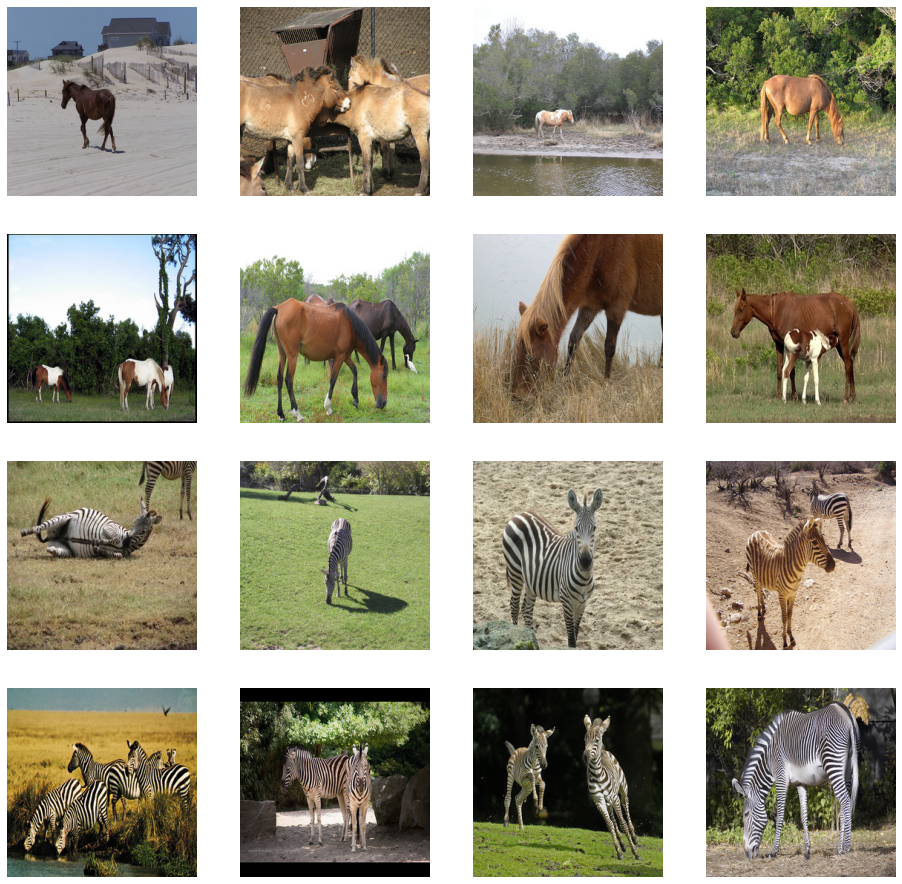

In [19]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0

# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_classA_pix = [os.path.join(train_classA_dir, fname) 
                for fname in train_classA_files[pic_index-8:pic_index]]
next_classB_pix = [os.path.join(train_classB_dir, fname) 
                for fname in train_classB_files[pic_index-8:pic_index]]

for i, img_path in enumerate(next_classA_pix + next_classB_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [20]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 2 - Summarize and Visualize Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Pre-process Data

In [21]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Pre-process Data has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [22]:
print('Loading and pre-processing the training images...')
train_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=default_image_size,
        batch_size=default_batch,
        class_mode='binary')
print('Number of image batches per epoch of modeling:', len(train_generator))

Loading and pre-processing the training images...
Found 2401 images belonging to 2 classes.
Number of image batches per epoch of modeling: 76


In [23]:
print('Loading and pre-processing the validation images...')
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=default_image_size,
        batch_size=default_batch,
        class_mode='binary')
print('Number of image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the validation images...
Found 260 images belonging to 2 classes.
Number of image batches per epoch of modeling: 9


In [24]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 3 - Pre-process Data completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Train and Evaluate Models

In [25]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Train and Evaluate Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [26]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [train_loss, train_metric]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == train_loss:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

## 4.a) Baseline Model

In [27]:
# Define the baseline model for benchmarking
def create_nn_model(conv1_filters=8, conv2_filters=16, conv3_filters=32, conv1_dropout=0, conv2_dropout=0, conv3_dropout=0,
                    dense_nodes=64, dense_dropout=0, opt_param=default_optimizer, init_param=default_kernel_init):
    nn_model = keras.Sequential([
        # This is the first convolution
        keras.layers.Conv2D(conv1_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param, input_shape=default_image_shape),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        # keras.layers.Dropout(conv1_dropout),
        # This is the second convolution
        keras.layers.Conv2D(conv2_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        # keras.layers.Dropout(conv2_dropout),
        # This is the third convolution
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.Conv2D(conv3_filters, (3,3), padding='same', activation='relu', kernel_initializer=init_param),
        keras.layers.MaxPooling2D((2,2), strides=(2,2)),
        # keras.layers.Dropout(conv3_dropout),
        # Flatten the results to feed into a DNN
        keras.layers.Flatten(),
        # keras.layers.Dropout(dense_dropout),
        # This is the last neuron hidden layer
        keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param),
        keras.layers.Dense(1, activation='sigmoid', kernel_initializer=init_param)
    ])
    nn_model.compile(loss=default_loss, optimizer=opt_param, metrics=default_metrics)
    return nn_model

In [28]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_0 = create_nn_model()
nn_model_history = nn_model_0.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
76/76 [==============================] - 8s 103ms/step - loss: 0.5346 - accuracy: 0.7534 - val_loss: 0.3375 - val_accuracy: 0.8731
Epoch 2/15
76/76 [==============================] - 8s 100ms/step - loss: 0.3013 - accuracy: 0.8817 - val_loss: 0.3860 - val_accuracy: 0.8462
Epoch 3/15
76/76 [==============================] - 8s 100ms/step - loss: 0.2554 - accuracy: 0.9009 - val_loss: 0.3205 - val_accuracy: 0.8769
Epoch 4/15
76/76 [==============================] - 8s 99ms/step - loss: 0.2587 - accuracy: 0.9055 - val_loss: 0.1937 - val_accuracy: 0.9308
Epoch 5/15
76/76 [==============================] - 8s 99ms/step - loss: 0.1856 - accuracy: 0.9254 - val_loss: 0.2316 - val_accuracy: 0.9192
Epoch 6/15
76/76 [==============================] - 8s 100ms/step - loss: 0.1634 - accuracy: 0.9363 - val_loss: 0.2217 - val_accuracy: 0.9192
Epoch 7/15
76/76 [==============================] - 8s 99ms/step - loss: 0.1469 - accuracy: 0.9434 - val_loss: 0.2191 - val_accuracy: 0.9385
Epoch 8/1

In [29]:
nn_model_0.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 32)        0

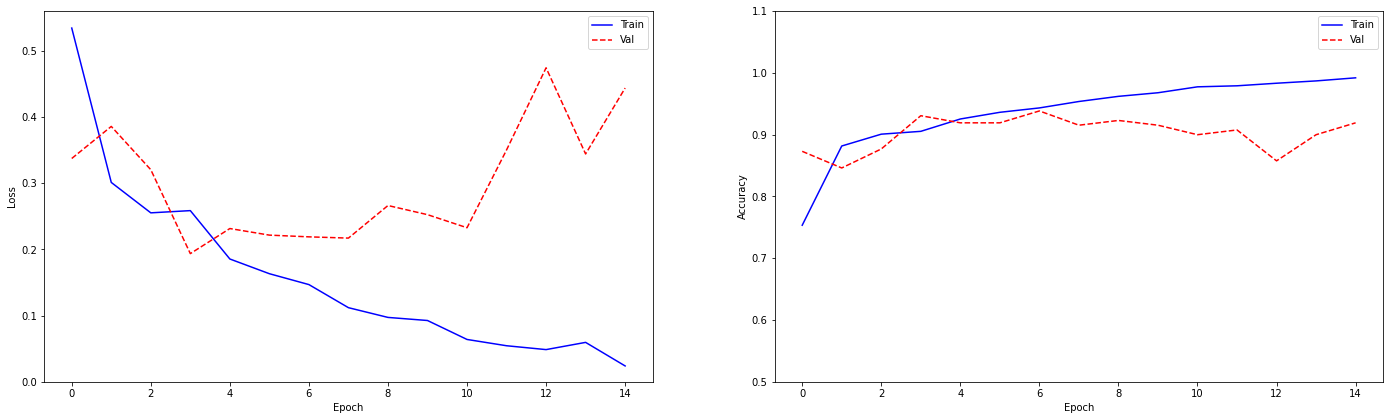

In [30]:
plot_metrics(nn_model_history)

## 4.b) Alternate Model One

In [31]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_1 = create_nn_model(conv1_filters=16, conv2_filters=32, conv3_filters=64, conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, dense_nodes=128, dense_dropout=0)
nn_model_history = nn_model_1.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
76/76 [==============================] - 8s 102ms/step - loss: 0.6416 - accuracy: 0.7293 - val_loss: 0.3451 - val_accuracy: 0.8346
Epoch 2/15
76/76 [==============================] - 8s 101ms/step - loss: 0.3281 - accuracy: 0.8771 - val_loss: 0.2682 - val_accuracy: 0.8885
Epoch 3/15
76/76 [==============================] - 8s 101ms/step - loss: 0.2852 - accuracy: 0.8984 - val_loss: 0.2332 - val_accuracy: 0.8923
Epoch 4/15
76/76 [==============================] - 8s 101ms/step - loss: 0.2199 - accuracy: 0.9096 - val_loss: 0.1955 - val_accuracy: 0.9231
Epoch 5/15
76/76 [==============================] - 8s 100ms/step - loss: 0.1890 - accuracy: 0.9259 - val_loss: 0.1547 - val_accuracy: 0.9346
Epoch 6/15
76/76 [==============================] - 8s 101ms/step - loss: 0.1396 - accuracy: 0.9463 - val_loss: 0.1391 - val_accuracy: 0.9423
Epoch 7/15
76/76 [==============================] - 8s 101ms/step - loss: 0.1301 - accuracy: 0.9525 - val_loss: 0.1888 - val_accuracy: 0.9346
Epoch 

In [32]:
nn_model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)       

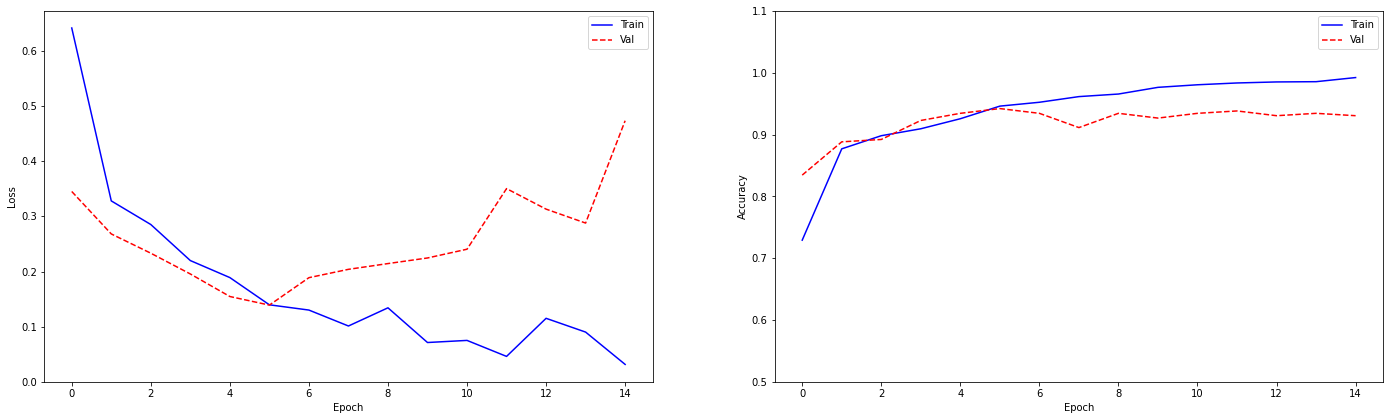

In [33]:
plot_metrics(nn_model_history)

## 4.c) Alternate Model Two

In [34]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_2 = create_nn_model(conv1_filters=32, conv2_filters=64, conv3_filters=128, conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, dense_nodes=256, dense_dropout=0)
nn_model_history = nn_model_2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
76/76 [==============================] - 8s 108ms/step - loss: 1.2978 - accuracy: 0.7189 - val_loss: 0.9062 - val_accuracy: 0.5231
Epoch 2/15
76/76 [==============================] - 8s 105ms/step - loss: 0.4378 - accuracy: 0.8247 - val_loss: 0.2478 - val_accuracy: 0.9038
Epoch 3/15
76/76 [==============================] - 8s 106ms/step - loss: 0.4350 - accuracy: 0.8780 - val_loss: 0.3146 - val_accuracy: 0.8615
Epoch 4/15
76/76 [==============================] - 8s 105ms/step - loss: 0.2527 - accuracy: 0.9030 - val_loss: 0.1768 - val_accuracy: 0.9231
Epoch 5/15
76/76 [==============================] - 8s 105ms/step - loss: 0.2183 - accuracy: 0.9279 - val_loss: 0.1369 - val_accuracy: 0.9385
Epoch 6/15
76/76 [==============================] - 8s 105ms/step - loss: 0.1487 - accuracy: 0.9467 - val_loss: 0.4268 - val_accuracy: 0.8115
Epoch 7/15
76/76 [==============================] - 8s 105ms/step - loss: 0.1785 - accuracy: 0.9496 - val_loss: 0.1079 - val_accuracy: 0.9538
Epoch 

In [35]:
nn_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 128)      

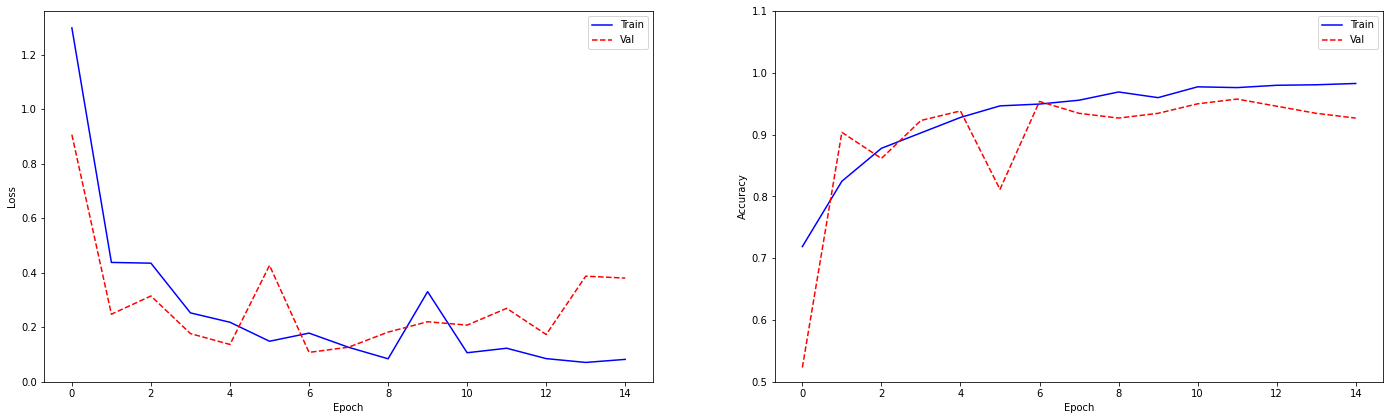

In [36]:
plot_metrics(nn_model_history)

## 4.d) Alternate Model Three

In [37]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_3 = create_nn_model(conv1_filters=48, conv2_filters=96, conv3_filters=192, conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, dense_nodes=384, dense_dropout=0)
nn_model_history = nn_model_3.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
76/76 [==============================] - 9s 116ms/step - loss: 3.9409 - accuracy: 0.6830 - val_loss: 0.4787 - val_accuracy: 0.7192
Epoch 2/15
76/76 [==============================] - 9s 113ms/step - loss: 0.4492 - accuracy: 0.8234 - val_loss: 0.2938 - val_accuracy: 0.8769
Epoch 3/15
76/76 [==============================] - 8s 112ms/step - loss: 0.3497 - accuracy: 0.8692 - val_loss: 0.2346 - val_accuracy: 0.9077
Epoch 4/15
76/76 [==============================] - 9s 112ms/step - loss: 0.2646 - accuracy: 0.9084 - val_loss: 0.1241 - val_accuracy: 0.9577
Epoch 5/15
76/76 [==============================] - 9s 113ms/step - loss: 0.2199 - accuracy: 0.9180 - val_loss: 0.1527 - val_accuracy: 0.9231
Epoch 6/15
76/76 [==============================] - 9s 114ms/step - loss: 0.1827 - accuracy: 0.9379 - val_loss: 0.2142 - val_accuracy: 0.9154
Epoch 7/15
76/76 [==============================] - 9s 112ms/step - loss: 0.1694 - accuracy: 0.9425 - val_loss: 0.1882 - val_accuracy: 0.9346
Epoch 

In [38]:
nn_model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 48)      1344      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 48)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 96)      41568     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 192)       166080    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 192)       331968    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 192)      

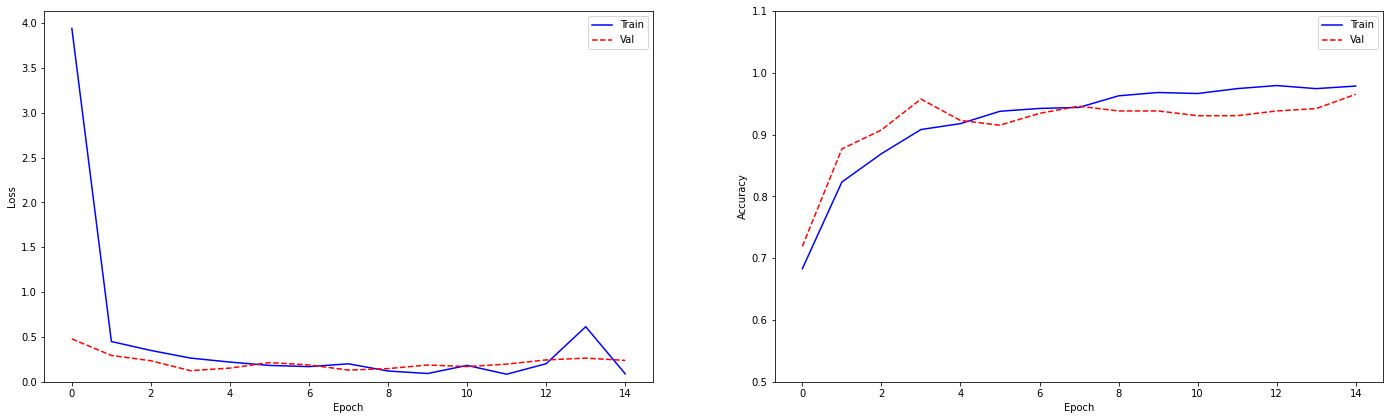

In [39]:
plot_metrics(nn_model_history)

## 4.e) Alternate Model Four

In [40]:
# Initialize the neural network model and get the training results for plotting graph
startTimeModule = datetime.now()
reset_random(seedNum)
nn_model_4 = create_nn_model(conv1_filters=64, conv2_filters=128, conv3_filters=256, conv1_dropout=0, conv2_dropout=0, conv3_dropout=0, dense_nodes=512, dense_dropout=0)
nn_model_history = nn_model_4.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
    validation_steps=len(validation_generator),
    epochs=default_epoch,
    verbose=1)
print('Total time for model fitting:', (datetime.now() - startTimeModule))

Epoch 1/15
76/76 [==============================] - 9s 122ms/step - loss: 6.4677 - accuracy: 0.6651 - val_loss: 0.3479 - val_accuracy: 0.8269
Epoch 2/15
76/76 [==============================] - 9s 120ms/step - loss: 0.5190 - accuracy: 0.7872 - val_loss: 0.3012 - val_accuracy: 0.8692
Epoch 3/15
76/76 [==============================] - 9s 119ms/step - loss: 0.3746 - accuracy: 0.8538 - val_loss: 0.2182 - val_accuracy: 0.9115
Epoch 4/15
76/76 [==============================] - 9s 119ms/step - loss: 0.3422 - accuracy: 0.9017 - val_loss: 0.3481 - val_accuracy: 0.8731
Epoch 5/15
76/76 [==============================] - 9s 119ms/step - loss: 0.2830 - accuracy: 0.9113 - val_loss: 0.1879 - val_accuracy: 0.9269
Epoch 6/15
76/76 [==============================] - 9s 120ms/step - loss: 0.1980 - accuracy: 0.9334 - val_loss: 0.1547 - val_accuracy: 0.9462
Epoch 7/15
76/76 [==============================] - 9s 118ms/step - loss: 0.2160 - accuracy: 0.9325 - val_loss: 0.1154 - val_accuracy: 0.9538
Epoch 

In [41]:
nn_model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 64, 64, 256)       590080    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 32, 32, 256)      

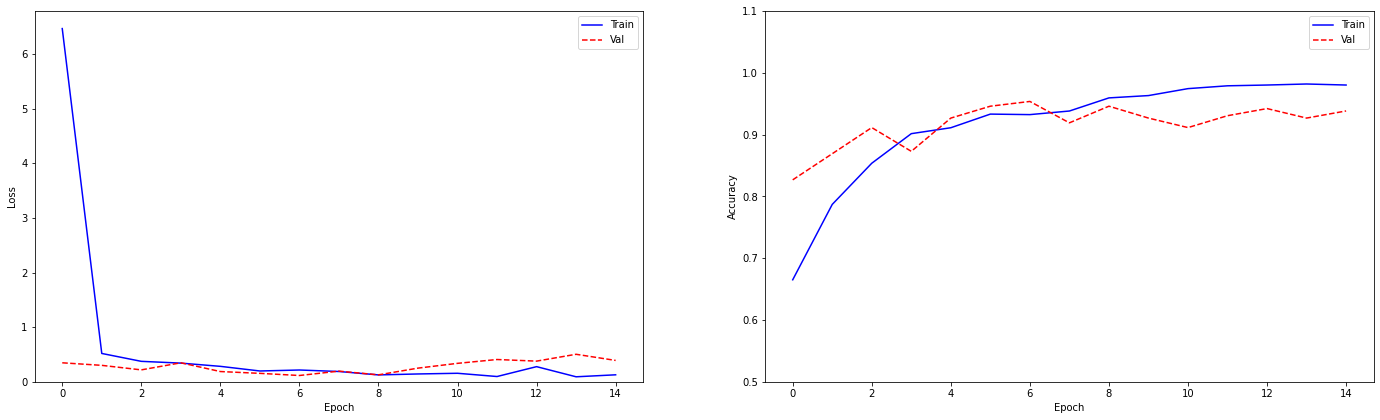

In [42]:
plot_metrics(nn_model_history)

In [43]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 4 - Train and Evaluate Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Present Analysis

In [44]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Present Analysis has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [48]:
final_model = nn_model_3

# Display a summary of the final model
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 48)      1344      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 128, 128, 48)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 96)      41568     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 64, 64, 96)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 64, 192)       166080    
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 192)       331968    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 32, 32, 192)      

In [46]:
if notifyStatus: status_notify('(TensorFlow Binary Classification) Task 5 - Finalize Model and Present Analysis completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [47]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:10:48.402581
